In [1]:
import pandas as pd
import numpy as np
np.random.seed(2018)

from collections import defaultdict

from sklearn.model_selection import GroupKFold

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

#boosting models => advanced options
import xgboost as xgb
#import catboost as ctb

import re
from tqdm import tqdm

from ml_metrics import rmsle

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df_train = pd.read_csv('../input/train.csv', parse_dates=['datetime'])
df_test = pd.read_csv('../input/test.csv', parse_dates=['datetime'])

In [3]:
def get_feats(df, black_list=['count', 'casual', 'registered']):
    feats = df.select_dtypes(include=[np.int64, np.float64]).columns.values
    
    def allow_feat(feat):
        for block_feat in black_list:
            if block_feat in feat: return False
        return True
    
    return [feat for feat in feats if allow_feat(feat) ]

get_feats(df_train)

['season',
 'holiday',
 'workingday',
 'weather',
 'temp',
 'atemp',
 'humidity',
 'windspeed']

In [4]:
def custom_validation(df, feats, target_variable='count', n_folds=3):
    X = df[feats].values
    y = df[target_variable].values

    groups = df['datetime'].dt.month.values
    group_kfold = GroupKFold(n_splits=n_folds)
    
    for train_idx, test_idx in group_kfold.split(X, y, groups):
        yield X[train_idx], X[test_idx], y[train_idx], y[test_idx]

def get_models():
    return [
        ('dt', DecisionTreeRegressor(max_depth=5, random_state=2018)),
        ('rf', RandomForestRegressor(max_depth=8, n_estimators=50, random_state=2018)),
        ('xgb', xgb.XGBRegressor(max_depth=10, n_estimators=500, random_state=2018)),
        
    ]
        
    
def draw_importance_features(model, df, importance_type='gain'):

    fscore = model.get_booster().get_score(importance_type=importance_type) #cover, gain, weight
    maps_name = dict([ ("f{0}".format(i), col) for i, col in enumerate(df.columns)])

    impdf = pd.DataFrame([ {'feature': maps_name[k], 'importance': fscore[k]} for k in fscore ])
    impdf = impdf.sort_values(by='importance', ascending=False).reset_index(drop=True)
    impdf['importance'] /= impdf['importance'].sum()
    impdf.index = impdf['feature']

    impdf.plot(kind='bar', title='{0} - Importance Features'.format(importance_type.title()), figsize=(12, 4))
    
    
def run_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    y_pred[y_pred<0] = 0
    return rmsle(y_test, y_pred)

## Feature engineering

In [5]:
def feats_engineering(df, offset_log=4):
    df['year']       = df['datetime'].dt.year
    df['month']      = df['datetime'].dt.month
    df['day']        = df['datetime'].dt.day
    df['hour']       = df['datetime'].dt.hour
    df['dayofweek']  = df['datetime'].dt.dayofweek
    df['weekofyear'] = df['datetime'].dt.weekofyear
    df['weekend']    = df.dayofweek.map(lambda x: int(x in [5,6]) )
    df['dayofyear']  = df['datetime'].dt.dayofyear
    
    df['rush_hour'] = df['datetime'].apply(lambda i: min([np.fabs(9-i.hour), np.fabs(20-i.hour)]))
    df.loc[:,('rush_hour')] = df['datetime'].apply(lambda i: np.fabs(14-i.hour))
    
    df['peak'] = df[['hour', 'workingday']].apply(lambda x: (0, 1)[(x['workingday'] == 1 and  ( x['hour'] == 8 or 17 <= x['hour'] <= 18 or 12 <= x['hour'] <= 12)) or (x['workingday'] == 0 and  10 <= x['hour'] <= 19)], axis = 1)

    if 'count' in df:
        df['count_log'] = np.log2( df['count'] + offset_log )
        df['registered_log'] = np.log2( df['registered'] + offset_log )
        df['casual_log'] = np.log2( df['casual'] + offset_log )

    return df

Model: dt, scores-mean: 0.6112958509608698, scores-std: 0.013712905051673177
Model: rf, scores-mean: 0.42424233621864876, scores-std: 0.011600245986429614
Model: xgb, scores-mean: 0.39212951546382485, scores-std: 0.006852519786258942


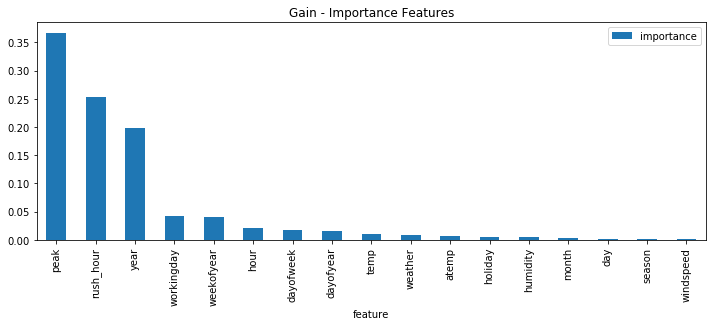

In [6]:
df = feats_engineering(df_train)
feats = get_feats(df)

for model_name, model in get_models():
    scores = []
    for X_train, X_test, y_train, y_test in custom_validation(df_train, feats):
        score = run_model(model, X_train, X_test, y_train, y_test)
        scores.append(score)
        
    print("Model: {0}, scores-mean: {1}, scores-std: {2}".format(model_name, np.mean(scores), np.std(scores)))

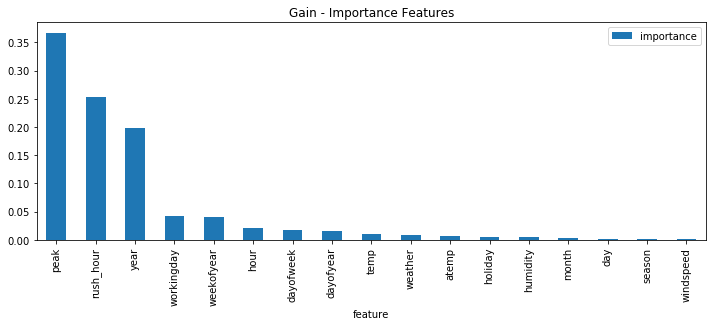

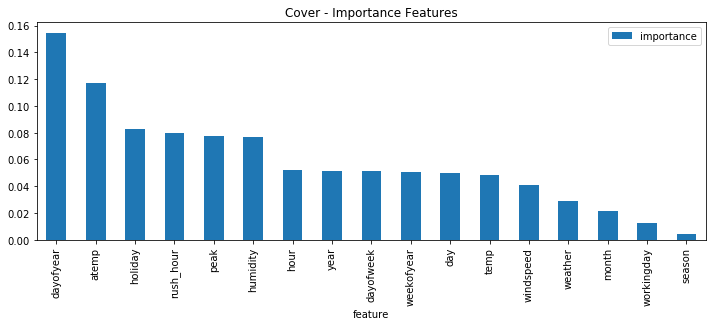

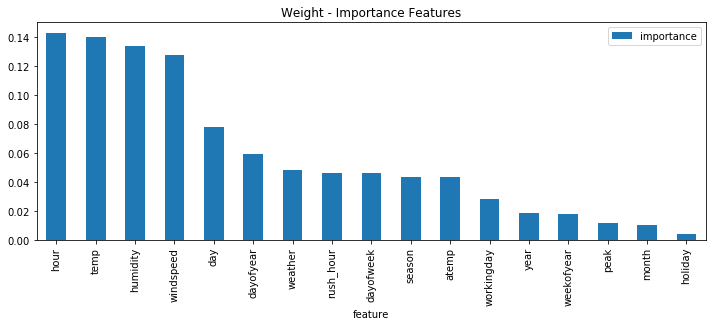

In [9]:
draw_importance_features(model, df[feats], importance_type='gain')
draw_importance_features(model, df[feats], importance_type='cover')
draw_importance_features(model, df[feats], importance_type='weight')

## Aggregation

In [10]:
median_year = df_train[ ['year', 'count'] ].groupby(['year']).median().to_dict()['count']
df_train['year'].map(lambda x: median_year[x]).head()

0    111
1    111
2    111
3    111
4    111
Name: year, dtype: int64

In [11]:
agg_feats = ['year', 'hour']
agg_func = np.mean

median_hour_year = df_train[ agg_feats + ['count'] ].groupby(agg_feats).agg(agg_func).to_dict()['count']
new_feat = '{0}_{1}'.format( agg_func.__name__, "_".join(agg_feats) )
df_train[agg_feats].apply(lambda x: median_hour_year[ tuple(dict(x).values()) ], axis=1).head()

0    43.563877
1    26.831858
2    19.307692
3    10.056872
4     5.255814
dtype: float64

## Aggregation (more advanced)

In [12]:
df_train = feats_engineering(df_train)
df_test  = feats_engineering(df_test)

agg_feats = [ 
    ['hour', 'year'],
    ['hour', 'season'],
    ['hour', 'month'],
]

for agg_feat in tqdm(agg_feats):
    for agg_func in [np.mean, np.median, np.sum, np.std]:
        dict_agg = df_train[ agg_feat + ['count'] ].groupby(agg_feat).agg(agg_func).to_dict()['count']
        new_feat = '{0}_{1}'.format( agg_func.__name__, "_".join(agg_feat) )

        default_dict_val = agg_func( list(dict_agg.values()))
        default_dict_agg = defaultdict(lambda: default_dict_val, dict_agg)

        df_train[new_feat] = df_train[agg_feat].apply(lambda x: dict_agg[ tuple(dict(x).values()) ], axis=1)
        df_test[new_feat] = df_test[agg_feat].apply(lambda x: default_dict_agg[ tuple(dict(x).values()) ], axis=1)

100%|██████████| 3/3 [00:10<00:00,  3.52s/it]


In [13]:
df = feats_engineering(df_train)
feats = get_feats(df)

for model_name, model in get_models():
    scores = []
    for X_train, X_test, y_train, y_test in custom_validation(df_train, feats):
        score = run_model(model, X_train, X_test, y_train, y_test)
        scores.append(score)
        
    print("Model: {0}, scores-mean: {1}, scores-std: {2}".format(model_name, np.mean(scores), np.std(scores)))

Model: dt, scores-mean: 0.6359347094064609, scores-std: 0.025625066405889414
Model: rf, scores-mean: 0.4393113376560432, scores-std: 0.02122360410140027
Model: xgb, scores-mean: 0.3861042464277753, scores-std: 0.015502134133839012


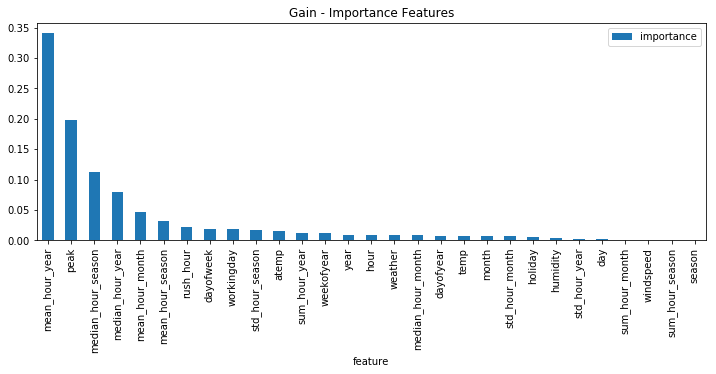

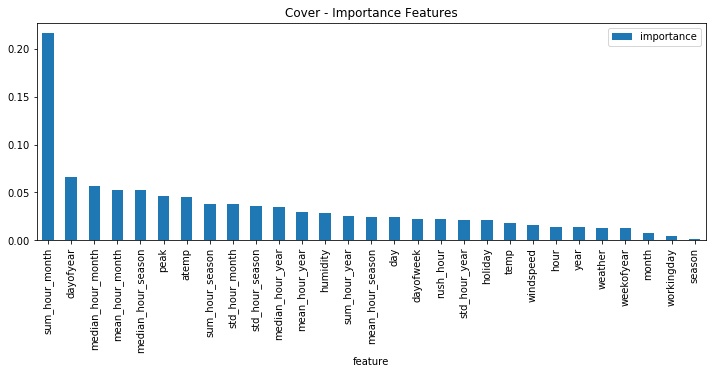

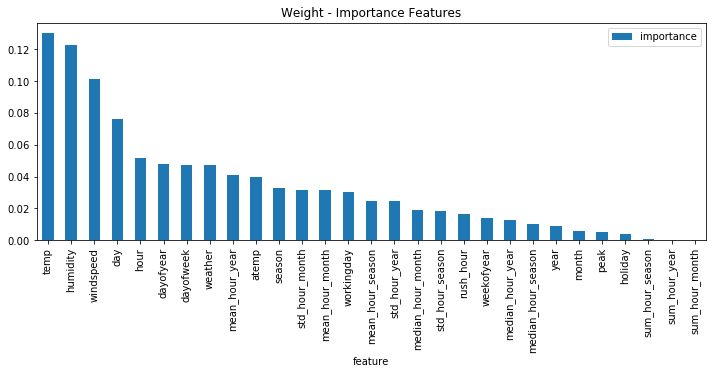

In [14]:
draw_importance_features(model, df[feats], importance_type='gain')
draw_importance_features(model, df[feats], importance_type='cover')
draw_importance_features(model, df[feats], importance_type='weight')

## Submit => 0.47117

In [39]:
X = df_test[feats].values
y_pred = model.predict(X)
y_pred[y_pred<0] = 0
df_test['count'] = y_pred
df_test[ ['datetime', 'count'] ].to_csv('../output/agg_xgboost.csv', index=False)

![](../images/agg_xgb_0.47117.png)

![](../images/0.47117.png)
Looks much better, than previous result (0.67), but a bit worse than expected... why? Because **overfitting** :). 

Let's add logarithm transformation from previous step.

### Predict log2(count)

In [15]:
df = feats_engineering(df_train)
feats = get_feats(df)

groups = df_train['datetime'].dt.month.values
group_kfold = GroupKFold(n_splits=3)
    
X = df[feats].values

count = df_train['count'].values
offset_log = 6
count_log = np.log2( count + offset_log)

scores = []
for train_idx, test_idx in group_kfold.split(X, count, groups):

    model = xgb.XGBRegressor(max_depth=10, n_estimators=500, random_state=2018)
    model.fit(X[train_idx], count_log[train_idx])
    count_log_pred = model.predict(X[test_idx])
    
    count_pred = np.exp2( count_log_pred ) - offset_log

    score = rmsle(count[test_idx], count_pred)
    scores.append(score)

np.mean(scores), np.std(scores)

(0.35276305712281308, 0.0094144233491770812)

## log2(registered) & log2(casual)

In [16]:
df = feats_engineering(df_train)
feats = get_feats(df)

groups = df_train['datetime'].dt.month.values
group_kfold = GroupKFold(n_splits=3)
    
X = df[feats].values
offset_log = 3

registered = df['registered'].values
registered_log = np.log2(registered + offset_log)

casual = df['casual'].values
casual_log = np.log2(casual + offset_log)

count = df['count'].values
count_log = np.log2(count + offset_log)

scores = []
for train_idx, test_idx in group_kfold.split(X, count, groups):
    model = xgb.XGBRegressor(max_depth=10, n_estimators=500, random_state=2018)
    model.fit(X[train_idx], registered_log[train_idx])
    registered_log_pred = model.predict(X[test_idx])
    registered_pred = np.exp2(registered_log_pred) - offset_log
    
    model = xgb.XGBRegressor(max_depth=10, n_estimators=500, random_state=2018)
    model.fit(X[train_idx], casual_log[train_idx])
    casual_log_pred = model.predict(X[test_idx])
    casual_pred = np.exp2(casual_log_pred) - offset_log
    
#     model = xgb.XGBRegressor(max_depth=10, n_estimators=500, random_state=2018)
#     model.fit(X[train_idx], count_log[train_idx])
#     count_log_pred = model.predict(X[test_idx])
#     count_pred_1 = np.exp2(count_log_pred) - offset_log
    
    count_pred = registered_pred + casual_pred
#     count_pred = 0.7*(registered_pred + casual_pred) + 0.3*count_pred_1
    
    score = rmsle(count[test_idx], count_pred)
    scores.append(score)

np.mean(scores), np.std(scores)

(0.34729558082626261, 0.011014949731136391)

##  Submit => 0.39996

In [17]:
train = feats_engineering(df_train)
test = feats_engineering(df_test)

feats = get_feats(train)
X_train, X_test = train[feats].values, test[feats].values

offset_log = 3

registered = train['registered'].values
registered_log = np.log2(registered + offset_log)

casual = train['casual'].values
casual_log = np.log2(casual + offset_log)

count = train['count'].values
count_log = np.log2(count + offset_log)

In [18]:
model_inst = xgb.XGBRegressor
model_params = {'max_depth':10, 'n_estimators':500, 'random_state':2018}

# model_inst = RandomForestRegressor
# model_params = {'n_estimators': 1000, 'max_depth': 15, 'random_state': 0, 'min_samples_split' : 5, 'n_jobs': -1}


model_registered = model_inst(**model_params)
model_registered.fit(X_train, registered_log)

model_casual = model_inst(**model_params)
model_casual.fit(X_train, casual_log)

registered_log_pred = model_registered.predict(X_test)
registered_pred = np.exp2(registered_log_pred) - offset_log

casual_log_pred = model_casual.predict(X_test)
casual_pred = np.exp2(casual_log_pred) - offset_log

test['count'] = registered_pred + casual_pred

In [19]:
test[ ['datetime', 'count'] ].to_csv('../output/xgb_agg24_log_registered_casual.csv', index=False)

![](../images/0.39996.png)